## TMDB - Systematische Evaluierung

In [153]:
import pandas as pd
import numpy as np
from datetime import datetime

In [154]:
df_links = pd.read_csv("ml-25m/links.csv")
df_tmdb_movies = pd.read_csv("tmdb_movies.csv", sep="\t")

# rename id column so that we can merge later
df_tmdb_movies.rename(columns={'id':'tmdbId'}, inplace=True)

In [155]:
# merge movielens movies with tmdb movies
df_movies = pd.merge(df_links, df_tmdb_movies, on='tmdbId')
df_movies.head()

,movieId,imdbId,tmdbId,Unnamed: 0,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,895,105729,79782.0,0,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
1,895,105729,79782.0,13349,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
2,181393,1684935,79782.0,0,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
3,181393,1684935,79782.0,13349,False,/s2bpgVhpWODDfoADW78IpMDCMTR.jpg,NaN,1783810,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",NaN,...,2010-06-11,0,110,"[{'english_name': 'Czech', 'iso_639_1': 'cs', ...",Released,NaN,Venice,False,7.0,13
4,1115,114472,141210.0,1,False,NaN,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 27, 'nam...",NaN,...,2012-10-12,0,6,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,The Sleepover,False,6.6,8


In [156]:
# extract data from dictionaries and list, separate key values by '|'

def extract_values(data):
    return data.apply(lambda x: '|'.join([i['name'] for i in eval(x)]))

df_movies['genres'] = extract_values(df_movies["genres"])
df_movies['spoken_languages'] = extract_values(df_movies["spoken_languages"])
df_movies['production_companies'] = extract_values(df_movies['production_companies'])
df_movies['production_countries'] = extract_values(df_movies['production_countries'])

# belongs_to_collection

KeyboardInterrupt: 

In [ ]:
# define columns that are not usefull
# adult is dropped because there are only 3 adult films. which makes it useless to use for our model
cols = [
    "imdbId",
    "Unnamed: 0",
    "backdrop_path",
    "homepage",
    "poster_path",
    "imdb_id",
    "original_title",
    "video",
    "status",
    "adult"
]

# drop columns defined above
df_movies2 = df_movies.drop(df_movies[cols], axis=1)

In [ ]:
# reorder columns for better overview
col_order = [
    "movieId", 
    "title", 
    "genres", 
    "overview", 
    "tagline",
    "release_date", 
    "vote_average", 
    "vote_count", 
    "popularity", 
    "runtime", 
    "original_language",
    "spoken_languages", 
    "production_companies",
    "production_countries",
    "revenue",
    "budget",
    "belongs_to_collection", 
]

df_movies2 = df_movies2[col_order]

In [ ]:
# remove duplicate rows (there are some duplicate movies with different movieId's, thats why we use difference)
df2 = df_movies2.drop_duplicates(subset=df_movies2.columns.difference(["movieId"]))

In [ ]:
# replace empty field with np.nan
df2 = df2.replace("", np.nan)

In [ ]:
# print number of NA's in each column
print(df2.isna().sum())

movieId                      0
title                        0
genres                     320
overview                   161
tagline                  11164
release_date                 0
vote_average                 0
vote_count                   0
popularity                   0
runtime                      0
original_language            0
spoken_languages          1131
production_companies      3610
production_countries      1869
revenue                      0
budget                       0
belongs_to_collection    18069
dtype: int64


In [ ]:
# print number of NA's in each column
print(df2.isna().sum())

In [ ]:
# drop rows with NAN overview --> overview is very important for the recommender model
df2 = df2.dropna(subset=["overview"])

In [169]:
df2

,movieId,title,genres,overview,tagline,release_date,vote_average,vote_count,popularity,runtime,original_language,spoken_languages,production_companies,production_countries,revenue,budget,belongs_to_collection
0,895,Venice,Drama|Romance,An atmospheric coming-of-age story featuring a...,NaN,2010-06-11,7.000,13,1.246,110,pl,Český|Deutsch|Polski|Pусский,Akson Studio|ITI Cinema,Poland,0,1783810,NaN
4,1115,The Sleepover,Comedy|Horror,"The town of Derry has a secret, but no one tol...",NaN,2012-10-12,6.600,8,0.600,6,en,English,NaN,United States of America,0,0,NaN
5,2223,The Farmer's Wife,Drama,"As her surroundings are invaded by outsiders, ...",NaN,2012-06-20,10.000,1,0.600,18,en,English,NaN,NaN,0,0,NaN
6,2679,A Place at the Table,Documentary,"Using personal stories, this powerful document...",One Nation. Underfed.,2012-03-22,6.700,20,2.337,84,en,English,NaN,United States of America,0,0,NaN
10,2894,Romance,Romance|Drama|Comedy,She's as hot as Britney Spears. Hotter. She pa...,NaN,2012-10-09,6.000,1,1.080,27,en,English,NaN,NaN,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19973,209133,The Riot and the Dance: Earth,Documentary,"This nature/science documentary, showcases the...",A Cinematic Celebration of Creation,2018-03-19,3.500,2,0.600,110,en,NaN,NaN,NaN,0,0,NaN
19974,209143,The Painting,Documentary|History|Animation,"For three and a half centuries, from the same ...",What is happening in that room?,2019-11-08,8.000,2,0.600,107,es,English|Français|Italiano|Español,TVE|TeleMadrid|Mare Films,Spain,0,0,NaN
19975,209145,Liberte,Drama|History,"1774, shortly before the French Revolution, so...",NaN,2019-09-04,5.400,22,3.829,132,fr,Français|Italiano|Deutsch,CNC|Medienboard Berlin-Brandenburg|Idéale Audi...,Germany|Spain|France|Portugal,0,0,NaN
19977,209157,We,Drama,During a scorching summer in a Belgian-Dutch b...,NaN,2018-07-12,5.938,56,6.512,100,nl,Nederlands,New AMS Film Company,Belgium|Netherlands,0,0,NaN


## User Profiles

In [ ]:
df_ratings = pd.read_csv("ml-25m/ratings.csv")

In [ ]:
lst_movieId = list(df2["movieId"])

# remove ratings from movies that we are not using
df_ratings = df_ratings[df_ratings["movieId"].isin(lst_movieId)]

# convert timestamp to datetime
df_ratings["date"] = [datetime.fromtimestamp(x) for x in df_ratings["timestamp"]]

# drop timestamp column
df_ratings.drop("timestamp", axis = 1, inplace = True)

# merge movies and ratings
df3 = pd.merge(df_ratings, df2, on = "movieId")

In [ ]:
# drop rows where the ratings were submitted before the movie released
df3 = df3[df3["date"] > df3["release_date"]]

# drop columns because they are useless now
df3.drop(["date", "release_date"], axis = 1, inplace = True)

In [ ]:
# No user has rated the same movie twice
df3[df3.duplicated(subset=["userId", "movieId"])]

,userId,movieId,rating,title,genres,overview,tagline,vote_average,vote_count,popularity,runtime,original_language,spoken_languages,production_companies,production_countries,revenue,budget,belongs_to_collection


In [ ]:
df3

,userId,movieId,rating,title,genres,overview,tagline,vote_average,vote_count,popularity,runtime,original_language,spoken_languages,production_companies,production_countries,revenue,budget,belongs_to_collection
0,3,73321,4.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
1,13,73321,3.5,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
2,38,73321,3.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
3,44,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
4,65,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,118,en,English,Alcon Entertainment|Silver Pictures,United States of America,157107755,80000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2652411,162067,200634,2.5,Eddie's Life Coach,Family|Animation,Eddie's mom signs her slacker son up for a dig...,NaN,5.500,6,1.691,4,en,English,Illumination,United States of America,0,0,NaN
2652412,162358,200168,3.0,Overtime War,Action|Comedy,Benefits and days off in war.,NaN,6.500,2,0.600,5,sv,svenska,Crazy Pictures,Sweden,0,0,NaN
2652413,162358,200172,4.0,Du ritar fult,Drama,"""You can't draw"", said the classmate. He didn'...",NaN,6.750,8,0.869,6,sv,NaN,Crazy Pictures,Sweden,0,0,NaN
2652414,162358,200182,4.0,Kuken brinner,Drama,Anders is in the hospital waiting nervously fo...,NaN,6.000,3,0.600,6,sv,svenska,Crazy Pictures,Sweden,0,0,NaN


## Testing

In [ ]:
# Programmierungs Fragen
# delete movies without genres (320 movies). correct?
# tagline more relevant then overview?
# 300 + movies with 0 runtime
# amount of ratings --> drop movies with under 10 vote counts?? (4000 movies)
# Venice movie duplicate --> why are you here?? are there other duplicates?
# Many movies with 0 revenue and 0 budget
# movie cast??
# ratings.csv von github lesen --> git lfs

# Generelle Fragen
# Wie beheben wir das Cold Start Problem? -

## EDA

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#### 1. Welches sind die am häufigsten geschauten Genres/Filme?


In [252]:
# separate genres and add them as columns, 0 = not in genre, 1 = in genre
dum = df3['genres'].str.get_dummies(sep = '|')
df4 = pd.concat([df3, dum], axis=1) 

In [253]:
df4

,userId,movieId,rating,title,genres,overview,tagline,vote_average,vote_count,popularity,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,3,73321,4.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,...,0,0,0,0,0,1,0,1,0,0
1,13,73321,3.5,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,...,0,0,0,0,0,1,0,1,0,0
2,38,73321,3.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,...,0,0,0,0,0,1,0,1,0,0
3,44,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,...,0,0,0,0,0,1,0,1,0,0
4,65,73321,5.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2652411,162067,200634,2.5,Eddie's Life Coach,Family|Animation,Eddie's mom signs her slacker son up for a dig...,NaN,5.500,6,1.691,...,0,0,0,0,0,0,0,0,0,0
2652412,162358,200168,3.0,Overtime War,Action|Comedy,Benefits and days off in war.,NaN,6.500,2,0.600,...,0,0,0,0,0,0,0,0,0,0
2652413,162358,200172,4.0,Du ritar fult,Drama,"""You can't draw"", said the classmate. He didn'...",NaN,6.750,8,0.869,...,0,0,0,0,0,0,0,0,0,0
2652414,162358,200182,4.0,Kuken brinner,Drama,Anders is in the hospital waiting nervously fo...,NaN,6.000,3,0.600,...,0,0,0,0,0,0,0,0,0,0


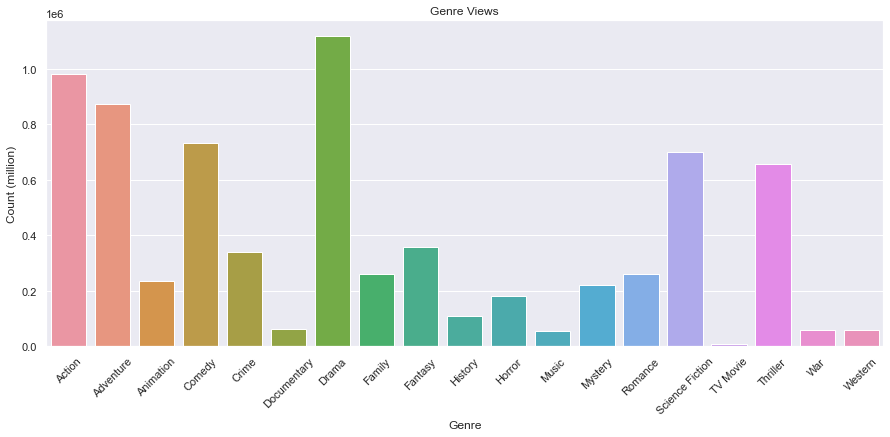

In [232]:
sns.set(rc={'figure.figsize':(15,6)})

ax = sns.barplot(data = df4.iloc[:,-19:].sum().reset_index(), x = "index", y = 0)
ax.set(xlabel='Genre', ylabel='Count (million)', title="Genre Views")
plt.xticks(rotation = 45)
plt.show()

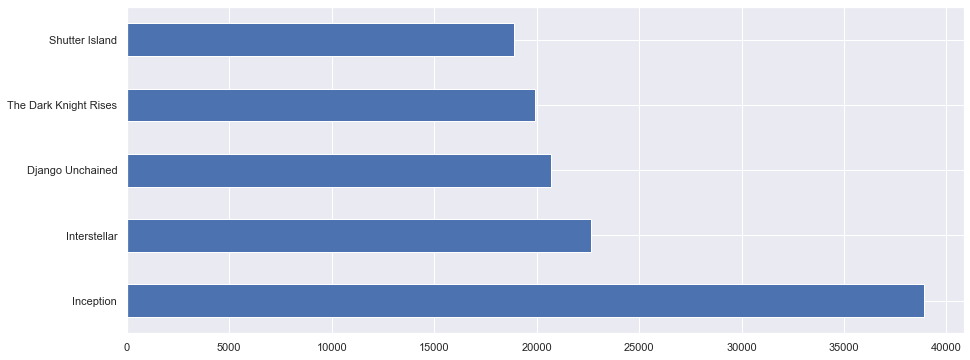

In [233]:
df3['title'].value_counts()[:5].plot(kind = "barh")
plt.show()

#### 2. Wie verteilen sich die Kundenratings gesamthaft und nach Genres?


In [234]:
# create 2d list with genre and all ratings
lst2 = []
for i in df4.iloc[:,-19:].columns:
    lst2.append([i, df4[df4[i] == 1]["rating"].tolist()])

# create dataframe from lst2 and unpack the list of ratings
df_genres = pd.DataFrame(lst2, columns = ["Genre", "Rating"])
df_genres_ratings = df_genres.explode("Rating")
df_genres_ratings.head()

,Genre,Rating
0,Action,4.0
0,Action,3.5
0,Action,3.0
0,Action,5.0
0,Action,5.0


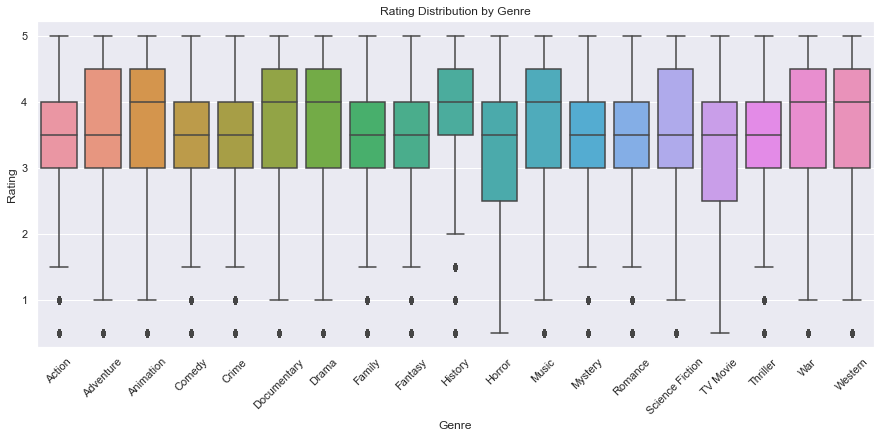

In [235]:
# plot rating by genre
sns.set(rc={'figure.figsize':(15,6)})
ax = sns.boxplot(data = df_genres_ratings, x = "Genre", y = "Rating")
ax.set(xlabel='Genre', ylabel='Rating', title="Rating Distribution by Genre")
plt.xticks(rotation = 45)
plt.show()

#### 3. Wie verteilen sich die mittleren Kundenratings pro Film?

<AxesSubplot:ylabel='Frequency'>

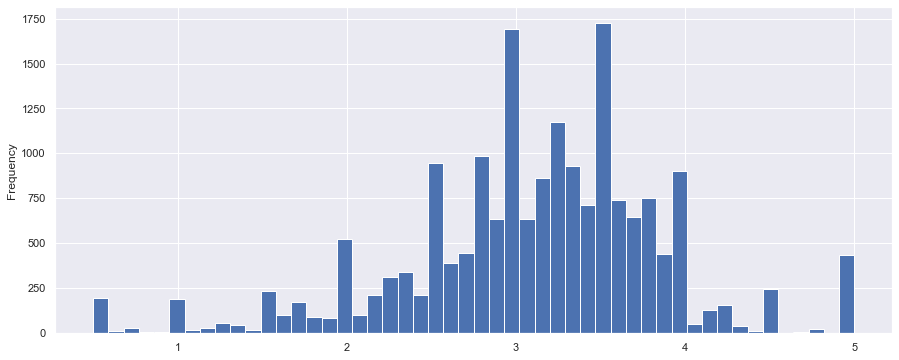

In [236]:
# group df4 by title and plot average rating
df4.groupby("title")["rating"].mean().sort_values(ascending = False).plot(kind = "hist", bins = 50)

#### 4. Wie stark streuen die Ratings von individuellen Kunden?

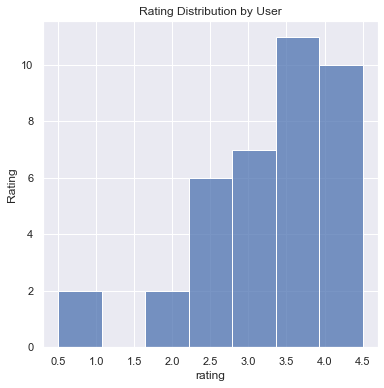

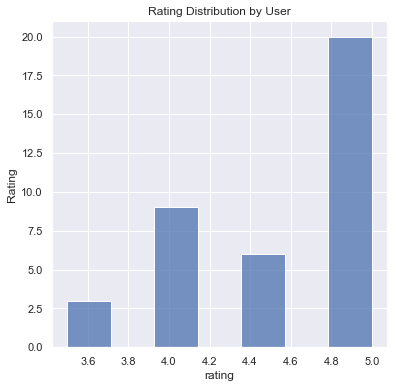

In [237]:
def user_rating(id):
    # seaborn boxplot ratings from random user
    sns.set(rc={'figure.figsize':(6,6)})

    ax = sns.histplot(data = df4[df4["userId"] == id], x = "rating")
    ax.set(ylabel='Rating', title="Rating Distribution by User")
    plt.show()

user_rating(13)
user_rating(44)

#### 5. Welchen Einfluss hat die Normierung der Ratings pro Kunde auf deren Verteilung?

In [254]:
# df4 normalize rating group by userId
df7 = df4.groupby(["userId"], as_index=False)["rating"].mean()
#df4["rating_std"] = df4.groupby("userId").std("rating")

df7.rename(columns={"rating": "rating_mean"}, inplace = True)

df7["rating_std"] = df4.groupby("userId")["rating"].transform("std")

df4 = pd.merge(df4, df7, on = "userId")
df4

,userId,movieId,rating,title,genres,overview,tagline,vote_average,vote_count,popularity,...,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,rating_mean,rating_std
0,3,73321,4.0,The Book of Eli,Action|Thriller|Science Fiction,"A post-apocalyptic tale, in which a lone man f...",Some will kill to have it. He will kill to pro...,6.776,5256,41.843,...,0,0,0,1,0,1,0,0,3.648148,0.501868
1,3,74458,4.0,Shutter Island,Drama|Thriller|Mystery,World War II soldier-turned-U.S. Marshal Teddy...,Some places never let you go.,8.190,20555,62.077,...,0,1,0,0,0,1,0,0,3.648148,0.501868
2,3,74789,4.0,Alice in Wonderland,Family|Fantasy|Adventure,"Alice, now 19 years old, returns to the whimsi...",You're invited to a very important date.,6.613,12436,97.193,...,0,0,0,0,0,0,0,0,3.648148,0.501868
3,3,76077,2.0,Hot Tub Time Machine,Science Fiction|Comedy|Adventure,A malfunctioning time machine at a ski resort ...,Kick some past,6.014,2079,13.560,...,0,0,0,1,0,0,0,0,3.648148,0.501868
4,3,76093,4.0,How to Train Your Dragon,Fantasy|Adventure|Animation|Family,As the son of a Viking leader on the cusp of m...,One adventure will change two worlds,7.798,11240,90.369,...,0,0,0,0,0,0,0,0,3.648148,0.501868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2647807,111274,105144,5.0,Bare Knuckles,Action|Adventure|Drama|Thriller,Women will go to extreme lengths for those the...,She fought for everything.,3.500,4,1.802,...,0,0,0,0,0,1,0,0,5.000000,0.506309
2647808,98350,194532,5.0,He's Out There,Horror|Thriller,"On vacation at a remote lake house, a mother a...",NaN,5.812,239,8.152,...,0,0,0,0,0,1,0,0,5.000000,0.668800
2647809,68706,198795,5.0,No Half Measures: Creating the Final Season of...,Documentary,A documentary about the making of season five ...,NaN,8.457,93,34.470,...,0,0,0,0,0,0,0,0,5.000000,1.186217
2647810,113006,130682,1.5,Muck,Horror,After narrowly escaping an ancient burial grou...,The Lucky Ones are Already Dead,3.000,78,7.016,...,0,0,0,0,0,0,0,0,1.500000,0.508483


In [ ]:
df4["rating_norm"] = (df4["rating"] - df4["rating_mean"]) / df4["rating_std"]
df4

In [239]:
# group df4 by userId and normalize rating
df6 = df4.groupby("userId")["rating"].mean() 
df6["std"] = df4.groupby("userId")["rating"].std()

df6["rating_norm"] = 

df6

SyntaxError: invalid syntax (Temp/ipykernel_16580/3737954205.py, line 5)

In [ ]:

df4["rating_norm"] = (df4["rating"] - df4["rating"].mean()) / df4["rating"].std()
df4["rating_norm"]

0          0.442215
1         -0.036708
2         -0.515632
3          1.400063
4          1.400063
             ...   
2652411   -0.994556
2652412   -0.515632
2652413    0.442215
2652414    0.442215
2652415    0.442215
Name: rating_norm, Length: 2647812, dtype: float64

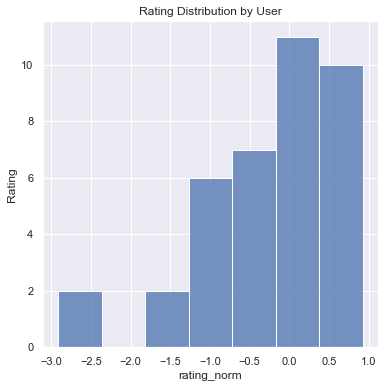

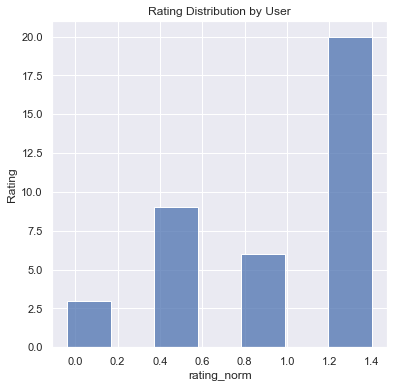

In [ ]:
def user_rating(id):
    sns.set(rc={'figure.figsize':(6,6)})

    ax = sns.histplot(data = df4[df4["userId"] == id], x = "rating_norm")
    ax.set(ylabel='Rating', title="Rating Distribution by User")
    plt.show()

user_rating(13)
user_rating(44)